In [2]:
### Import packages 
import networkx as nx # for handling graphs/networks 
import numpy as np # for basic scientific computing 
import pandas as pd # for basic scientific computing 
import matplotlib.pyplot as plt # for plotting
import matplotlib.gridspec as gridspec

import seaborn as sns

from scipy.special import binom

from scipy.integrate import solve_ivp
import Koopman_source as kp
from math import comb
#from copy import copy
import csv

from scipy.special import expit


In [3]:

## Toy example from the Steven's note
# Discrete dynamical system

def toy_d1(t, x0, mu0, lambda0): # Here, d1 stands for the first discrete example.
    # t must be a positive integer.
    # x0 is the initial value x(0) = x0
    #mu0, lambda0 = kappa[0], kappa[1]
    x_mat = np.zeros([len(x0),t]) # matrix for saving trajectories. It does not save the initial value.
    x_old = x0.copy()
    x_new = x_old
    for i in range(t):
        x_new[0] = (1+mu0)*x_old[0]
        x_new[1] = (1+lambda0)*x_old[1]
        x_mat[:,i] = x_new
    return x_mat

def Lorenz(x_old, sigma0, rho0, beta0):
    dt = 0.1
    x_new = x_old.copy()
    x_new[0] = x_old[0] + sigma0 * (x_old[1]-x_old[0])*dt
    x_new[1] = x_old[1] + (x_old[0]*(rho0-x_old[2]) - x_old[2])*dt
    x_new[2] = x_old[2] + (x_old[0]*x_old[2] - beta0*x_old[2])*dt
    return x_new

def Lotka_Voltera(x_old, rho0, sigma0, alpha0, beta0):
    dt = 1
    x_new = x_old.copy()
    x_new[0] = rho0 * x_old[0] * (1- x_old[0]) - alpha0 * x_old[0] * x_old[1]
    x_new[1] = sigma0 * x_old[1] + beta0 * x_old[0] * x_old[1]
    return x_new

def psi_id(x):
    return x
    
def psi_d1(x):
    return x

def psi_d2(x):
    d = 2 # the number of variables or the dimension of a dynamical system.
    max_order = 2
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            obs[idx] = np.power(x[0], i-j) * np.power(x[1], j)
            idx += 1
    return obs

def Laguerre_poly(x, n):
    if n==0:
        return 1
    if n==1:
        return -x+1
    if n>1:
        return ((2*n-1-x)*Laguerre_poly(x, n-1) - (n-1)*Laguerre_poly(x, n-2))/n
    # if n==2:
    #     return 1/2 * (x**2 - 4*x + 2)
    # if n==3:
    #     return 1/6 * (-x**3 + 9*x**2 - 18*x + 6)
    # if n==4:
    #     return 1/24 * (x**4 - 16*x**3 + 72*x**2 - 96*x + 24)
    # print("For now, n must be less than 5!")
    # return None

def psi_d2_Laguerre(x):
    d = 2 # the number of variables or the dimension of a dynamical system.
    max_order = 2
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            obs[idx] = Laguerre_poly(x[0], i-j) * Laguerre_poly(x[1], j)
            idx += 1
    return obs

def psi_Laguerre(x, d, max_order):
    # d: the number of variables or the dimension of a dynamical system.
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = [] #np.zeros(num_obs) # the total number of observable functions, psi_m's.
    idx = 0 
    ind_mat =[]
    inc_ord = True
    if d == 3:
        if inc_ord == True:
            for i in range(max_order+1):
                for j in range(i+1):
                    for k in range(j+1):
                        obs.append(Laguerre_poly(x[0], i-j) * Laguerre_poly(x[1], j-k) * Laguerre_poly(x[2], k))
                        ind_mat.append([i-j,j-k,k])
                        # idx += 1
        else:
            for i in range(max_order+1):
                for j in range(max_order-i+1):
                    for k in range(max_order-i-j+1):
                        obs.append(Laguerre_poly(x[0], i) * Laguerre_poly(x[1], j) * Laguerre_poly(x[2], k))
                        ind_mat.append([i,j,k])
    if d == 2:
        if inc_ord == True:
            for i in range(max_order+1):
                for j in range(i+1):
                    obs.append(Laguerre_poly(x[0], i-j) * Laguerre_poly(x[1], j))
                    ind_mat.append([i-j,j])
        else:
            for i in range(max_order+1):
                for j in range(max_order-i+1):
                    obs.append(Laguerre_poly(x[0], i) * Laguerre_poly(x[1], j))
                    ind_mat.append([i,j])
    
    return np.array(obs), ind_mat


### ====== Page-Rank Algorithm ======================
def pagerank(M, num_iterations=100, d=0.85):
    N = M.shape[1]
    
    # Initialize the PageRank vector
    v = np.ones(N) / N
    
    # Compute the column sum
    out_degree = np.sum(M, axis=0)
    
    # Normalize the adjacency matrix
    M_hat = M / out_degree
    
    # PageRank iteration
    for _ in range(num_iterations):
        v_next = (1 - d) / N + d * M_hat.dot(v)
        if np.allclose(v, v_next):
            return v_next
        v = v_next
    
    return v

def subsampled_pagerank(M, num_iterations=100, d=0.85, subsample_rate=0.1, epsilon=1e-8):
    N = M.shape[0]
    
    # Normalize the adjacency matrix
    M_hat = M / np.sum(M, axis=0)
    
    # Initialize the PageRank vector
    v = np.ones(N) / N
    
    for _ in range(num_iterations):
        v_prev = v.copy()
        
        # Subsampling
        mask = np.random.random(N) < subsample_rate
        subsampled_M = M_hat[:, mask]
        subsampled_v = v_prev[mask]
        
        # PageRank update
        v = (1 - d) / N + d * subsampled_M.dot(subsampled_v / subsample_rate)
        
        # Check for convergence
        if np.sum(np.abs(v - v_prev)) < epsilon:
            break
    
    return v / np.sum(v)


In [4]:
np.random.seed(123)

## Compute a Koopman matrix from simulated data.
sigma0 = 10.0
rho0 = 20.0
beta0 = 3.0

#K_true = np.array([[1+mu0, 0, 0], [0, 1+lambda0, -lambda0], [0, 0, (1+mu0)**2]])
#G_inv_true = np.array([[11/4, -3/4, -5/8], [-3/4, 3/4, 1/8], [-5/8, 1/8, 3/16]])
#G_true = np.array([[2,1,6],[1,2,2,],[6,2,24]])
#np.matmul(G_inv_true, G_true)
#A_true = np.matmul(G_true, np.transpose(K_true))

#x0 = [2,1]

model = "Lorenz"
sequential = False

if model == "d2_ans":
    d = 2
elif model == "d2":
    d = 2 # the number of variables (=the dimension) of the original dynamical system.
elif model == "d3":
    d = 3
elif model == "Lorenz":
    d = 3
elif model == "Lotka_Voltera":
    d = 2
#M = 100 # the number of observed data. 

orth_basis = True

M_max = 500 # the maximum number of observed data. 
n_repeat = 2 # the number of repetition of approximaing the Koopman matrix. 
max_order = 5
N = comb(d+max_order,d) # the total number of observable functions, psi_m's. 
# N1 = 4 
# N2 = N - N1

In [5]:
x_init = np.array([1,1,1])

K_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_pinv_accum = np.zeros([N,N,M_max,n_repeat])
A_approx_accum = np.zeros([N,N,M_max,n_repeat])
P_accum = np.zeros([M_max,M_max,M_max,n_repeat])

for rr in range(n_repeat):
    if np.mod(rr, 2) == 0:
        print(rr)
    x_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    y_mat_total = np.zeros([d,M_max])

    K_approx = np.zeros([N,N,M_max])
    G_approx = np.zeros([N,N,M_max])
    G_pinv = np.zeros([N,N,M_max])
    A_approx = np.zeros([N,N,M_max])

    for i in range(M_max):
        if sequential == True:
            if model == "Lorenz":
                y_mat_total[:,i] = Lorenz(x_mat_total[:,i], sigma0, rho0, beta0)
                if i+1 < M_max:
                    x_mat_total[:,i+1] = y_mat_total[:,i]
        else:
            if model == "Lorenz":
                y_mat_total[:,i] = Lorenz(x_mat_total[:,i], sigma0, rho0, beta0)

    Psi_X = np.zeros([M_max,N])
    Psi_Y = np.zeros([M_max,N])

    for i in range(M_max):
        if model == "Lorenz":
            Psi_X[i,:], ind_mat = psi_Laguerre(x_mat_total[:,i], d, max_order)
            Psi_Y[i,:] = psi_Laguerre(y_mat_total[:,i], d, max_order)[0]

    G_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_X[np.ix_(range(1),range(N))])
    G_pinv[:,:,0] = np.linalg.pinv(G_approx[:,:,0])
    A_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_Y[np.ix_(range(1),range(N))])
    K_approx[:,:,0] = np.matmul(G_pinv[:,:,0], A_approx[:,:,0])

    for M in range(2,M_max+1):  
        G_approx[:,:,M-1] = G_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_X[np.ix_(range(M-1,M),range(N))])
        G_pinv[:,:,M-1] = np.linalg.pinv(G_approx[:,:,M-1])
        A_approx[:,:,M-1] = A_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_Y[np.ix_(range(M-1,M),range(N))])
        K_approx[:,:,M-1] = np.matmul(G_pinv[:,:,M-1], A_approx[:,:,M-1])

    G_approx_accum[:,:,:,rr] = G_approx
    G_pinv_accum[:,:,:,rr] = G_pinv
    A_approx_accum[:,:,:,rr] = A_approx
    K_approx_accum[:,:,:,rr] = K_approx

0


In [29]:
eig_v = pagerank(abs(K_approx[:,:,M_max-1]), 5000, 0.85)
eig_v2 = subsampled_pagerank(abs(K_approx[:,:,M_max-1]), 5000, 0.85, 0.2)
ranked_idx = np.argsort(eig_v)[::-1]
ranked_idx2 = np.argsort(eig_v2)[::-1]

Text(956.631313131313, 0.5, 'Rows')

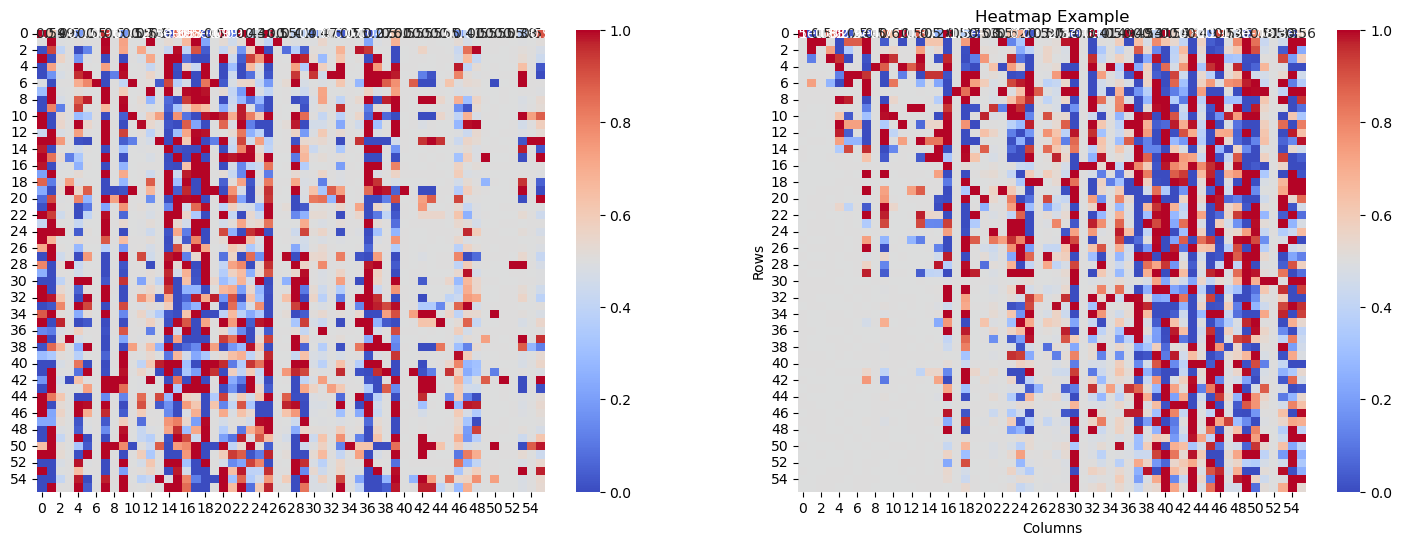

In [34]:
mixed_idx = np.random.permutation(N)

data = K_approx[:,:,M_max-1]
data_mx = K_approx[np.ix_(mixed_idx,mixed_idx, [M_max-1])]
data_pr = K_approx[np.ix_(ranked_idx,ranked_idx, [M_max-1])]
data_subpr = K_approx[np.ix_(ranked_idx2,ranked_idx2, [M_max-1])]
data = np.squeeze(data)
data_mx = np.squeeze(data_mx)
data_pr = np.squeeze(data_pr)
data_subpr = np.squeeze(data_subpr)
# Create a heatmap
#fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
fig1, ax1 = plt.subplots(1,3,figsize = (15,4))
#plt.figure(figsize=(8, 6))
sns.heatmap(expit(data*10), ax=ax1[0], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(data_mx*10), ax=ax1[1], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(data_pr*10), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)# sns.heatmap(expit(data_subpr*10), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(expit(data*100), annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(1/(1+np.exp(-data)), annot=True, cmap='coolwarm', cbar=True)

# Add title and labels
plt.title("Heatmap Example")
plt.xlabel("Columns")
plt.ylabel("Rows")


In [21]:
K_approx[:,:,M_max-1]

array([[ 1.00000000e+00, -6.17196875e-14, -1.80000000e+00, ...,
         1.21920400e-01, -9.99147129e-03,  8.31404003e-03],
       [-2.40183921e-13, -8.67184902e-14,  1.90000000e+00, ...,
         2.29839757e-01, -3.31199130e-01,  1.48570964e-02],
       [ 6.22860990e-14,  1.00000000e+00,  1.00000000e+00, ...,
         1.68532872e-01, -2.09101226e-02, -1.87856375e-03],
       ...,
       [ 1.40088602e-13, -5.63994971e-13, -3.03124355e-13, ...,
         2.88318247e-01,  5.58983960e-02, -5.67964172e-03],
       [ 1.00709311e-13, -9.78497623e-13, -9.47060518e-13, ...,
        -6.25189970e-01,  4.68984543e-01, -1.50152355e-02],
       [ 3.92718493e-14,  1.28886545e-12,  2.80209910e-12, ...,
        -9.19323738e-01,  2.02917627e-02,  2.55127133e-01]])

In [9]:
for i in ranked_idx:
    print(ind_mat[i])

[3, 2, 0]
[2, 3, 0]
[0, 1, 4]
[5, 0, 0]
[4, 1, 0]
[0, 2, 3]
[1, 4, 0]
[3, 1, 1]
[0, 0, 5]
[2, 2, 1]
[0, 3, 2]
[4, 0, 1]
[1, 3, 1]
[3, 0, 2]
[2, 1, 2]
[0, 4, 1]
[1, 1, 3]
[1, 0, 4]
[1, 2, 2]
[2, 2, 0]
[2, 0, 3]
[3, 1, 0]
[0, 1, 3]
[1, 3, 0]
[4, 0, 0]
[0, 5, 0]
[2, 1, 1]
[1, 0, 3]
[0, 0, 4]
[3, 0, 1]
[1, 2, 1]
[0, 2, 2]
[1, 1, 2]
[2, 1, 0]
[2, 0, 2]
[0, 0, 3]
[1, 2, 0]
[0, 3, 1]
[3, 0, 0]
[0, 4, 0]
[0, 1, 2]
[1, 0, 2]
[1, 1, 1]
[2, 0, 1]
[1, 1, 0]
[0, 0, 2]
[0, 2, 1]
[2, 0, 0]
[0, 3, 0]
[1, 0, 1]
[0, 1, 1]
[0, 2, 0]
[0, 0, 1]
[1, 0, 0]
[0, 1, 0]
[0, 0, 0]


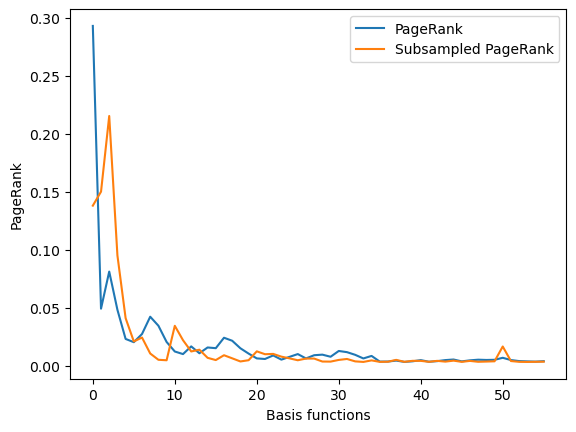

In [8]:
plt.plot(eig_v)
plt.xlabel("Basis functions")
plt.ylabel("PageRank")
plt.plot(eig_v2)
plt.xlabel("Basis functions")
plt.ylabel("PageRank")
plt.legend(["PageRank", "Subsampled PageRank"])

In [19]:
A1 = np.array([[1,5],[2,10], [7, 3]])
A1_hat = A1 / np.sum(A1, axis=0)
A1_hat
A1.shape


(3, 2)